In [1]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
#!pip install mne

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math



from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test



In [4]:
from common import EEG_fif

In [5]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
runs = [3, 4, 7, 8, 11, 12]
#runs = [3,5,7]
subjects = [i for i in range(6,7)]
#subjects = [1]
#runs = [6,10,14]
print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
freq = (1., 45.)


raw=raw.notch_filter(np.arange(50, 125, 50))

print("Filter done")
#raw=eeg.raw_ica()


/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S006/S006R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S006/S006R04.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S006/S006R07.fif) does not conform to MNE naming conventions. A

Raw done
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)

Filter done


/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S006/S006R08.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S006/S006R11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S006/S006R12.fif) does not conform to MNE naming conventions. A

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


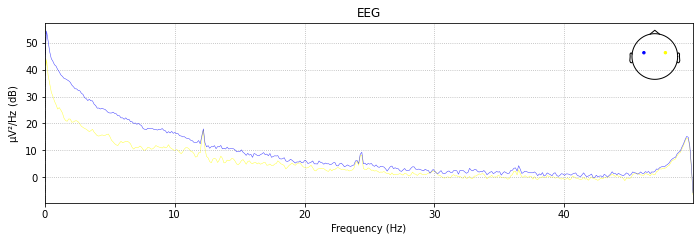

Using matplotlib as 2D backend.


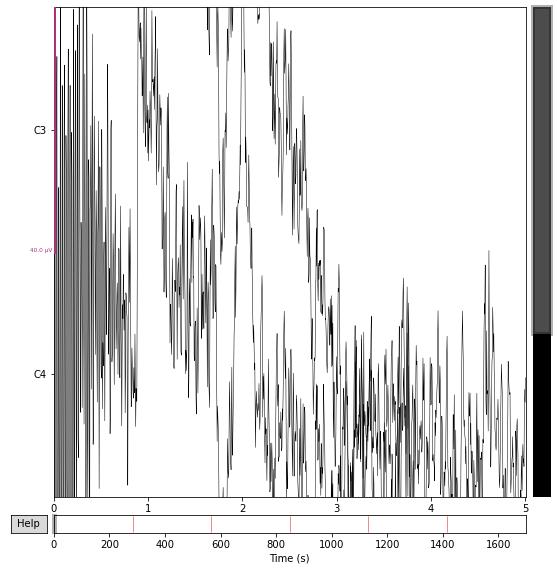

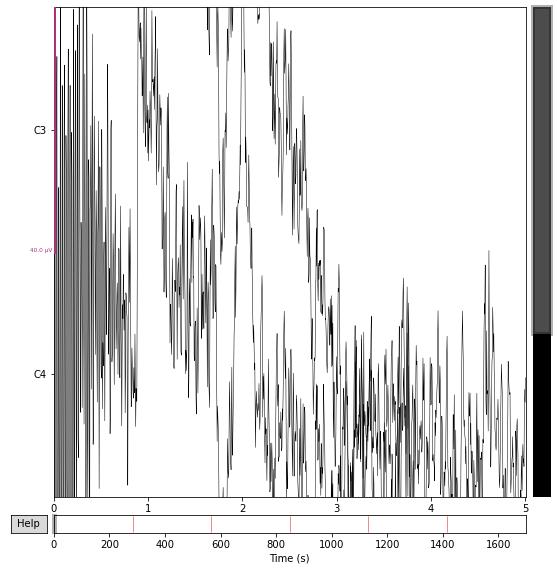

In [6]:
raw.plot_psd(fmax=50)
raw.plot(duration=5, n_channels=2)

In [7]:
epochs=eeg.epochs_visu(raw,tmin=-1)

360 events found
Event IDs: [1 2 4]
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 1251 original time points ...
0 bad epochs dropped


/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:655: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [8]:
#raw=raw.apply_hilbert()

In [9]:
raw.ch_names

['C3', 'C4', 'STIM MARKERS']

In [10]:
raw

<Raw | S006R03.fif, 3 x 424519 (1698.1 s), ~9.7 MB, data loaded>

In [11]:

freqs = np.arange(8, 9)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1,0 )  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tmin, tmax = -1, 4


In [12]:
epochs

Number of events,180
Events,1: 902: 903: 0
Time range,-1.000 – 4.000 sec
Baseline,-1.000 – 0.000 sec


In [13]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
tfr.data.shape

Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


(180, 2, 1, 626)

In [14]:
event_ids = {'1': 1, '2': 2}

In [15]:
X=tfr.data
y=tfr.events[:, -1]
y-=1

In [16]:
tfr.data.shape

(180, 2, 1, 626)

In [17]:
X = X.reshape((180,2,626))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train size (126, 2, 626) (126,)
Test size (54, 2, 626) (54,)


In [19]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).float()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

num_step =math.ceil(len(train_loader.dataset) / batch_size)

In [20]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda(0) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda(0) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [21]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 626 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [24]:
import wandb
wandb.login()


wand = wandb.init(
        
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"physionet_LSTM_2ch_2class", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0000001,
      "architecture": "LSTM",
      "dataset": "Nutapol T.",
      "epochs": 10000000,
      "weightname":"physionet_LSTM_2ch_2class",
      "num_step_per_epoch" : num_step, 
        
      }
    )

config = wand.config
print(config.num_step_per_epoch)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Test/Test_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test/Test_loss,█▆▆▅▄▃▃▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train/train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_loss,█▇▄▅▆▅▃▂▂▁▂▁▁▂▂▂▃▄▂▄▃▃▄▃▁▃▄▁▂▂▃▂▁▂▂▂▁▁▁▁
Test/Test_accuracy,50.0
Test/Test_loss,0.25957
train/train_accuracy,50.0
train/train_loss,0.25975


4


In [ ]:
from common import train_lstm


net = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train.shape[1]).cuda(0) 
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
criterion = nn.MSELoss()
train_loss,valid_loss,train_accuracy,valid_accuracy =train_lstm(
    model = net,
    gpu_num = 0,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    wand = wand
         )


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

Epoch 1/10000000, Tr Loss: 0.4152, Tr Acc: 50.0000, Val Loss: 0.4097, Val Acc: 50.0000


/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

Epoch 101/10000000, Tr Loss: 0.4142, Tr Acc: 50.0000, Val Loss: 0.4259, Val Acc: 50.0000
Epoch 201/10000000, Tr Loss: 0.4120, Tr Acc: 50.0000, Val Loss: 0.4123, Val Acc: 50.0000
Epoch 301/10000000, Tr Loss: 0.4089, Tr Acc: 50.0000, Val Loss: 0.4276, Val Acc: 50.0000
Epoch 401/10000000, Tr Loss: 0.4075, Tr Acc: 50.0000, Val Loss: 0.4155, Val Acc: 50.0000
Epoch 501/10000000, Tr Loss: 0.4066, Tr Acc: 50.0000, Val Loss: 0.4143, Val Acc: 50.0000
Epoch 601/10000000, Tr Loss: 0.4057, Tr Acc: 50.0000, Val Loss: 0.4064, Val Acc: 50.0000
Epoch 701/10000000, Tr Loss: 0.4060, Tr Acc: 50.0000, Val Loss: 0.4225, Val Acc: 50.0000
Epoch 801/10000000, Tr Loss: 0.4020, Tr Acc: 50.0000, Val Loss: 0.4105, Val Acc: 50.0000
Epoch 901/10000000, Tr Loss: 0.4016, Tr Acc: 50.0000, Val Loss: 0.3920, Val Acc: 50.0000
Epoch 1001/10000000, Tr Loss: 0.4026, Tr Acc: 50.0000, Val Loss: 0.4017, Val Acc: 50.0000
Epoch 1101/10000000, Tr Loss: 0.4005, Tr Acc: 50.0000, Val Loss: 0.4002, Val Acc: 50.0000
Epoch 1201/10000000